In [71]:
%pip install scikit-learn==1.5.2 scipy graphviz matplotlib sklearn2pmml==0.113.0 setuptools tabulate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Paula\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [72]:
import os
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import sklearn2pmml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from typing import List, Tuple, Union
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt



In [73]:
os.environ['DATASET'] = 'UPB2012'
os.environ['DISSEMINATION'] = 'true'
os.environ['MODEL'] = 'decision'

In [74]:

dataset_filename = f"../dataset/{os.environ.get('DATASET')}/useful_messages"


is_dissemination = os.environ.get('DISSEMINATION') == 'true'

if is_dissemination:
    dataset_filename += "_dissemination"

dataset_filename += '.csv'


df = pd.read_csv(dataset_filename, index_col=0)


In [75]:
df['usefulTransfer'] = df['usefulTransfer'].fillna(0)
df

,messageId,messageSource,messageHopCount,oldRelayId,oldFriendWithDestination,oldRelayBattery,oldCommonCommunity,oldDataMemory,newRelayId,newFriendWithDestination,newRelayBattery,newCommonCommunity,newDataMemory,usefulTransfer
0,4492,8,-1,0,2,0.657234,2,1.000,5,0,0.259491,0,1.000,0.0
1,61,3,-1,15,4,0.559201,2,1.000,8,7,0.473900,1,1.000,1.0
2,939,23,-1,3,6,0.042986,4,1.000,11,12,0.663113,5,1.000,1.0
3,2012,4,-1,5,0,0.032523,2,1.000,0,1,0.430266,4,1.000,1.0
4,556,4,-1,0,2,0.037928,2,1.000,5,0,0.681852,0,1.000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349995,578,5,-1,0,1,0.582257,4,1.000,5,0,0.184514,2,1.000,0.0
349996,2965,4,-1,2,3,0.141238,4,1.000,4,1,0.101366,5,1.000,0.0
349997,1078,5,-1,0,1,0.909525,4,1.000,5,0,0.511782,2,1.000,0.0
349998,2895,0,-1,2,3,0.134155,2,0.288,0,2,0.227708,2,0.288,0.0


In [76]:
df = df.rename(columns={'oldFriendWithDestination': 'oldFriendsCommonTopicWithMessage'})
df = df.rename(columns={'oldCommonCommunity': 'oldCommunityCommonTopicWithMessage'})
df = df.rename(columns={'newFriendWithDestination': 'newFriendsCommonTopicWithMessage'})
df = df.rename(columns={'oldFriendWithDestination': 'oldCommunityCommonTopicWithMessage'})


In [77]:
df.columns


Index(['messageId', 'messageSource', 'messageHopCount', 'oldRelayId',
       'oldFriendsCommonTopicWithMessage', 'oldRelayBattery',
       'oldCommunityCommonTopicWithMessage', 'oldDataMemory', 'newRelayId',
       'newFriendsCommonTopicWithMessage', 'newRelayBattery',
       'newCommonCommunity', 'newDataMemory', 'usefulTransfer'],
      dtype='object')

In [ ]:

columns_to_be_removed = ['messageId', 'messageSource', 'oldRelayId', 'newRelayId']

if os.environ.get('DISSEMINATION') == 'true':
    columns_to_be_removed.append('messageHopCount')
    

df = df.drop(columns=columns_to_be_removed)
positive_df = df.loc[df["usefulTransfer"] == 1]
negative_df = df.loc[df["usefulTransfer"] == 0]

lesser_len = positive_df.shape[0] if positive_df.shape[0] < negative_df.shape[0] else negative_df.shape[0]

positive_df = positive_df.sample(lesser_len)
negative_df = negative_df.sample(lesser_len)

balanced_df = pd.concat([positive_df, negative_df], ignore_index=True)
preprocessed_df = balanced_df.drop(columns="usefulTransfer").copy()

preprocessed_df

['messageId', 'messageSource', 'oldRelayId', 'newRelayId', 'messageHopCount']


,oldFriendsCommonTopicWithMessage,oldRelayBattery,oldCommunityCommonTopicWithMessage,oldDataMemory,newFriendsCommonTopicWithMessage,newRelayBattery,newCommonCommunity,newDataMemory
0,0,0.354722,0,1.0,2,0.752465,2,1.0
1,3,0.282396,4,1.0,1,0.242523,5,1.0
2,1,0.236400,4,1.0,3,0.276273,3,1.0
3,7,0.512257,4,1.0,12,0.043866,1,1.0
4,6,0.091794,4,1.0,2,0.287604,2,1.0
...,...,...,...,...,...,...,...,...
300013,3,0.287604,2,1.0,6,0.091794,4,1.0
300014,2,0.241250,2,1.0,2,0.201377,3,1.0
300015,0,0.243866,2,1.0,3,0.548056,3,1.0
300016,2,0.519560,3,1.0,2,0.426007,2,1.0


In [79]:


TransformerType = Union[FunctionTransformer, MinMaxScaler, StandardScaler, OneHotEncoder]

transformers: List[Tuple[str, TransformerType, List[str]]] = []

categorial_columns = []

if not is_dissemination:
    categorial_columns = [
        "oldFriendWithDestination",
        "oldCommonCommunity",
        "newFriendWithDestination",
        "newCommonCommunity",
    ]

standard_columns = [
    col
    for col in preprocessed_df.select_dtypes(include=["float64", "int64"]).columns
    if col and col not in categorial_columns
]


scaler = FunctionTransformer()

if os.environ['MODEL'] == 'svm':
    scaler = StandardScaler()
elif os.environ['MODEL'] == 'neural':
    scaler = MinMaxScaler()


transformers.extend([
        ("standard", scaler, standard_columns),
        ("onehotencoder", OneHotEncoder() if not is_dissemination else FunctionTransformer(), categorial_columns)
    ])

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="passthrough",
)

preprocessed_df = preprocessor.fit_transform(preprocessed_df)

print(f"Preprocessed matrix shape: {preprocessed_df.shape}")



X = balanced_df.copy().drop(columns=["usefulTransfer"])
result_df = pd.DataFrame(balanced_df["usefulTransfer"].copy().squeeze())
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(result_df)


print(f"Balanced dataframe columns: {balanced_df.columns}")


Preprocessed matrix shape: (300018, 8)
Balanced dataframe columns: Index(['oldFriendsCommonTopicWithMessage', 'oldRelayBattery',
       'oldCommunityCommonTopicWithMessage', 'oldDataMemory',
       'newFriendsCommonTopicWithMessage', 'newRelayBattery',
       'newCommonCommunity', 'newDataMemory', 'usefulTransfer'],
      dtype='object')


C:\Users\Paula\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [96]:

def train_decision_tree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    decission_tree_classifier = DecisionTreeClassifier(max_depth=5)

    # Build the pipeline
    decision_pipeline = Pipeline(
        [("preprocessor", preprocessor), ("classifier", decission_tree_classifier)]
    )

    decision_pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = decision_pipeline.predict(X_test)


    plt.figure(figsize=(100, 30))
    plot_tree(decision_pipeline.named_steps["classifier"], feature_names=X.columns, filled=True, fontsize=15)
    plt.show()


Decision tree model chosen


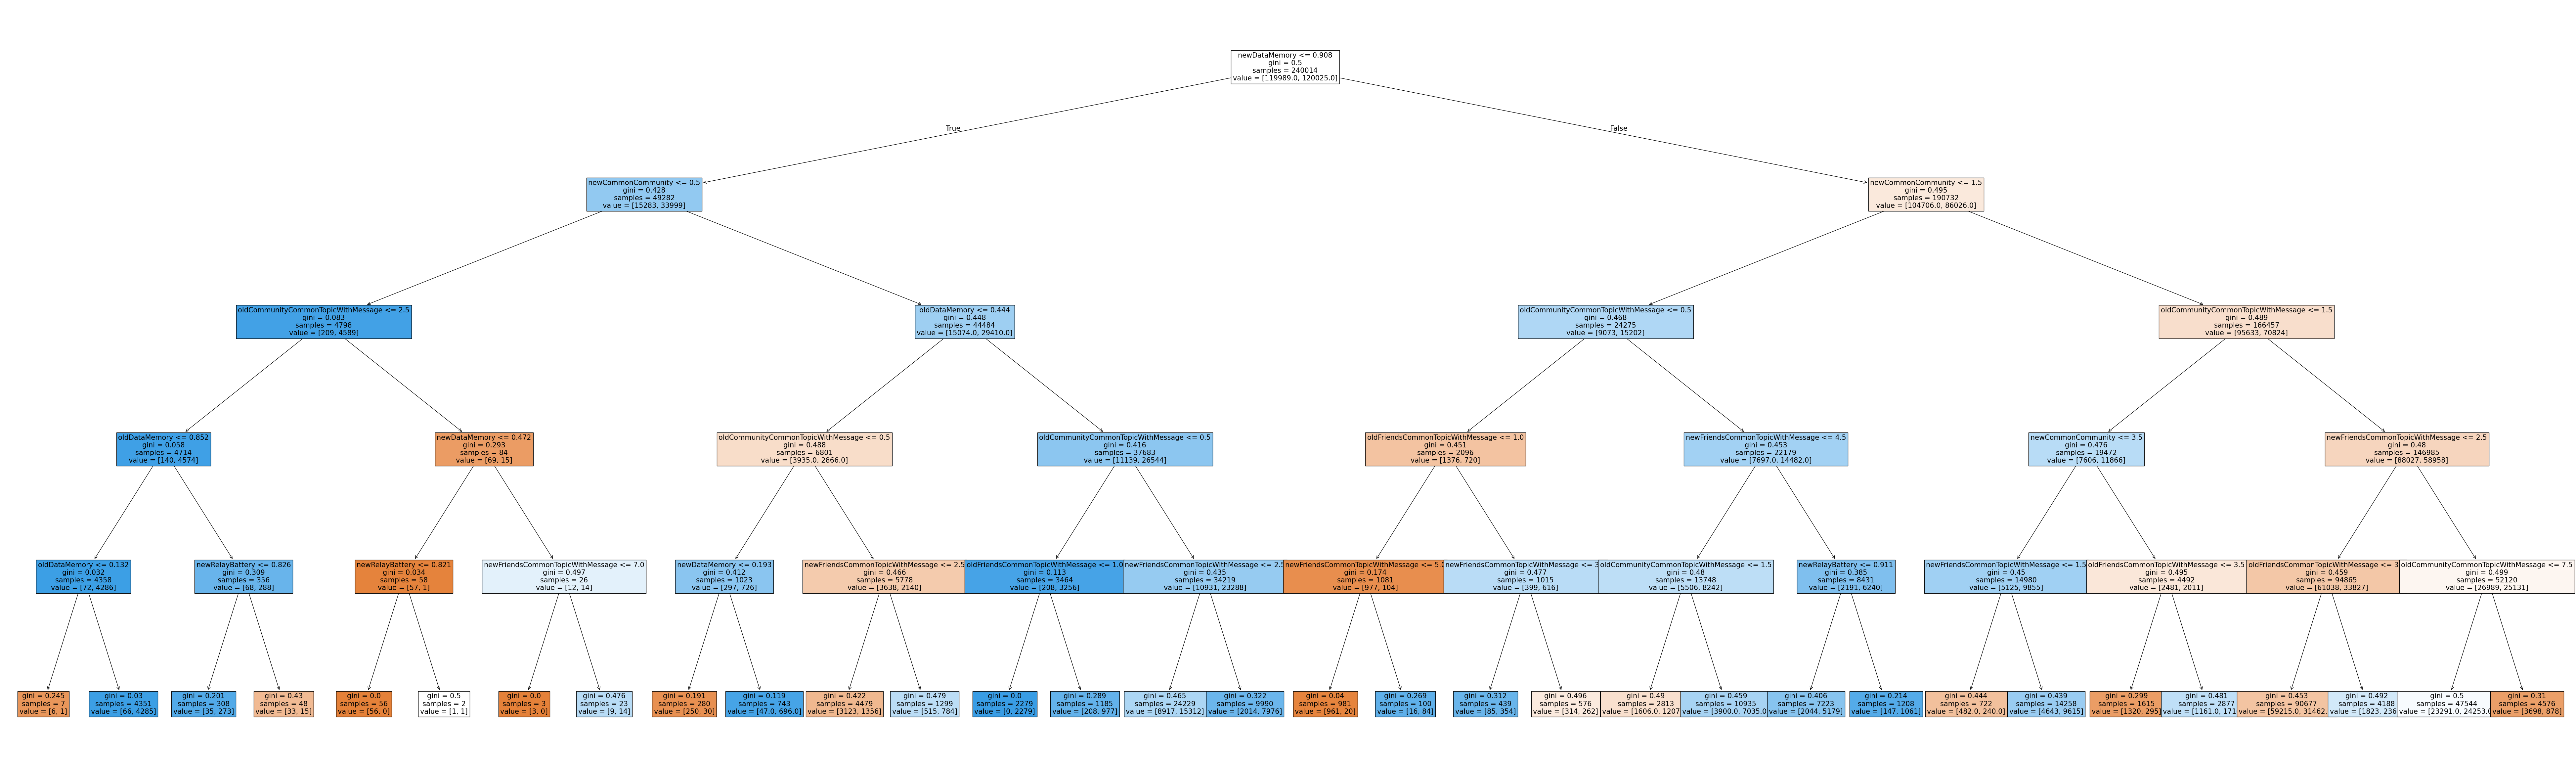

In [97]:


if os.environ.get("MODEL") == "rf":
    print("Random forest model chosen")
    train_random_forest(X, y)
elif os.environ.get("MODEL") == "neural":
    print("Neural network chosen")
    train_neural(X, y)
elif os.environ.get("MODEL") == "svm":
    print("SVM model chosen")
    train_svm(X, y)
elif os.environ.get("MODEL") == "decision":
    print("Decision tree model chosen")
    train_decision_tree(X, y)
